<h1> imports </h1>

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import numpy as np
import requests

import cv2
import matplotlib.pyplot as plt
import urllib.request
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time
import re   
import gender_guesser.detector as gender
from requests.exceptions import SSLError
from selenium.common.exceptions import WebDriverException, NoSuchElementException,TimeoutException, ElementNotInteractableException, ElementClickInterceptedException

In [159]:
Languages_list = ['Java','JavaScript','C','Python','PHP','Python3','Go',"Ruby","Csharp","Swift"]

<h1> Functions: Make list of challenge's names and links </h1>

In [8]:
driver = webdriver.Chrome(ChromeDriverManager().install())

def Chall_Names_List(driver, soup):
    chall_names_list = []

    titles = soup.find_all("div",{"class":"challenge-title"})
    for title in titles:
        t=title.find('a')['href']
        chall_names_list.append(t[13:])
        
    
    return chall_names_list

def make_challenges_hrefs_list():
    

    challenges_href = []
    driver.get('https://coderbyte.com/challenges')
    driver.find_element_by_css_selector("input[name='free']").click()
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    challenges_names = Chall_Names_List(driver, soup)
    
    
    challs_cards = soup.find_all("div",{"class":"challenge-actions"})
   
    for card in challs_cards:
      
        sol_href = card.find_all('a')
      
        string_list = str(sol_href).split()
        space = False
        for string in string_list:
            if(space == True):
                newString = newString +"%20"+ string
                if(string[-4:]=="View"):
                    space = False
                    challenges_href.append(newString[:-6])
            if(string.find('/solution')!=-1):
                space = True
                newString = "https://coderbyte.com/" + string[6:]
                

    return challenges_href, challenges_names # Links + Names of challs

[WDM] - Current google-chrome version is 91.0.4472
[WDM] - Get LATEST driver version for 91.0.4472
[WDM] - Driver [C:\Users\Noam\.wdm\drivers\chromedriver\win32\91.0.4472.101\chromedriver.exe] found in cache


<h1> Make challenge list </h1>

In [140]:
Challenges_list_href,Challenges_Names= make_challenges_hrefs_list()

<h1> Gender Detection </h1>

<h2> Check gender by emoji </h2>

In [10]:
Female_1 = cv2.imread("Female1.jpg")
Female_2 = cv2.imread("Female2.jpg")
Female_3 = cv2.imread("Female3.jpg")
Female_4 = cv2.imread("Female4.jpg")

Male_1 = cv2.imread("Male1.jpg")
Male_2 = cv2.imread("Male2.jpg")
Male_3 = cv2.imread("Male3.jpg")

None_img = cv2.imread("NoneIMG.jpg")

def check_female(img): # Female emojies
    female_and_female_dif1 = cv2.subtract(img,Female_1)
    female_and_female_diff1 = np.where(female_and_female_dif1)
    FandF1 = not np.any(female_and_female_diff1)

    female_and_female_dif2 = cv2.subtract(img,Female_2)
    female_and_female_diff2 = np.where(female_and_female_dif2)
    FandF2 = not np.any(female_and_female_diff2)

    female_and_female_dif3 = cv2.subtract(img,Female_3)
    female_and_female_diff3 = np.where(female_and_female_dif3)
    FandF3 = not np.any(female_and_female_diff3)

    female_and_female_dif4 = cv2.subtract(img,Female_4)
    female_and_female_diff4 = np.where(female_and_female_dif4)
    FandF4 = not np.any(female_and_female_diff4)


    return (FandF1 or FandF2 or FandF3 or FandF4)

def check_Male(img):# Male emojies
    male_and_male_dif = cv2.subtract(img,Male_1)
    male_and_male_diff = np.where(male_and_male_dif)
    MandM1 = not np.any(male_and_male_diff)
            
    male_and_male_dif = cv2.subtract(img,Male_2)
    male_and_male_diff = np.where(male_and_male_dif)
    MandM2 = not np.any(male_and_male_diff)
            
    male_and_male_dif = cv2.subtract(img,Male_3)
    male_and_male_diff = np.where(male_and_male_dif)
    MandM3 = not np.any(male_and_male_diff)
    

    return (MandM1 or MandM2 or MandM3)

def check_imogy_gender(img):
    gender = None
    try:
        if(img.shape!=(153, 153, 3)): # resizing image
            img = np.resize(img,(153, 153, 3))
    except AttributeError as error:
        return None
    
    if(check_female(img)==True):
        gender = 'Female'
    else:
        if(check_Male(img)==True):
            gender = 'Male'
            
    return gender

def get_gender_by_image(image_url, i):
    response = requests.get(image_url) # read image from url
    image_name = 'ImageNum' + str(i) + '.jpg'
    with open(image_name, 'wb') as file:
        file.write(response.content)
   
    img = cv2.imread(image_name)
    final_gender = check_imogy_gender(img)
    return final_gender

<h2> Detect Gender by user profile name and username </h2>

In [11]:
d = gender.Detector()

def calculate_gender(name, prob):
    name = name[0].upper() + name[1:] # First letter must be capital
    Gender = d.get_gender(name)
    Gender = Gender[0].upper() + Gender[1:] # Example: female -> Female
    return Gender

def Sub_and_check_name(new_name, prob): # Cut the last letter
    Gender = None
    for i in range(len(new_name)):
        ind = len(new_name)-i
        if(ind < 3): break
        new_name = new_name[:-1]
        Gender = calculate_gender(new_name, prob)
        if(Gender!= "Unknown" and Gender!="Andy" and Gender!= None): break
    return Gender

def Get_first_name(name): # split by cases, nums etc..

    # regex
    pattern = '[A-Z]+[a-z]+$'
    pattern_letter_num= '[A-Za-z]+[0-9]+$'

    new_name = name
    # searching pattern
    if re.search(pattern, name):
        for n, char in enumerate(name):
            if(char.isupper() and n!=0):
                new_name = name[:n]
                break
    if(new_name==name):
        letter_flag = any(x.isalpha() for x  in name)
        num_flag = any(x.isnumeric() for x in name)
        if(letter_flag and num_flag):
            start_with_alpha = False
            for n,x in enumerate(name):
                if(x.isalpha() and n==0): start_with_alpha = True
                if(start_with_alpha and x.isnumeric()): 
                    new_name = name[:n]
                    break
                if(start_with_alpha==False and x.isalpha): 
                    break
                    new_name = name[n:]


    if (new_name!=name and re.search(pattern_letter_num, new_name)):
        new_name = re.sub("[0-9]", "", new_name)
    return new_name



def Detect_by_cases(name, prob):
    Gender = None
    new_name = Get_first_name(name)
    Gender = calculate_gender(new_name, prob)
    if(Gender== None or Gender=="Unknown" or Gender=="Andy"):
        Gender = Sub_and_check_name(new_name, prob)
    return Gender


def get_gender_by_profile_name(link,prob):
    p_driver = webdriver.Chrome(ChromeDriverManager().install())
    Gender = None
    profile_link = "https://coderbyte.com/"+ link
    try:
        p_driver.get(profile_link)
        name = p_driver.find_element_by_class_name("realName").text.split()
        if(len(name)!=0):
            name = name[0] # Only first name
            Gender = calculate_gender(name, prob)
    except NoSuchElementException: pass
    except WebDriverException: pass
    p_driver.quit()
    return Gender
    
def find_gender(link, name, prob, image, i ):
    Gender = None
    detected_by = 0 # zero mean by user name, 1 means by emoji image
    Gender = get_gender_by_profile_name(link,prob) # First priority is by full name on the user's profile if exist
    # results can be: Mostly female, Mostly male, male, female, unkown or Andy
    if(Gender==None or Gender== "Unknown" or Gender=="Andy"):
        Gender = Detect_by_cases(name, prob)# Second priority is by Username
    if(Gender== None or Gender=="Unknown" or Gender=="Andy"):
        detected_by = 1
        Gender = get_gender_by_image(image, i)# Last priority is by emoji
    return Gender, detected_by

<h1> Main </h1>

<h2> Main data crawiling functions - extract codes and user's info </h2>

In [12]:
def selectLang(lang,url): # Select specific langauge from the challenge's page
    
    driver.get(url)
    time.sleep(1)
    try:    
        xpath = '//*[@id="challenge_leaderboard"]/div/div/div[2]/div/div[2]/span'
        driver.find_element_by_xpath(xpath).click()
        time.sleep(1)
        driver.find_element_by_css_selector("input[type='text']").send_keys(lang)
        driver.find_element_by_css_selector("input[type='text']").send_keys(Keys.ENTER)

    except NoSuchElementException: pass
    except ElementNotInteractableException: pass
    return driver
    
def data_process(html, lang,i): # extract all the details for each solution code
    clean_data_list = []
    soup = BeautifulSoup(html, 'html.parser')
    cards = soup.find_all("div", {"class": "comment card"})

    for card in cards:
        data_dict = {}
        sol_code = card.find("code",{"class":"hljs"})
        sol_card = card.find("div",{"class":"submitter"})
        User_name = sol_card.find('a').text
        User_url = sol_card.find('a')['href']
        
        data_dict['User_Name'] = User_name
        data_dict['User_img'] = sol_card.find('img')['src']
        data_dict['User_url'] = User_url
        if(Challenges_Names[i]=="SQL Member Count"): break
        data_dict['Challange_Name'] = Challenges_Names[i]
        data_dict['Programming_Lang'] = lang
        data_dict['Sol_Code'] = sol_code.get_text()
        data_dict['User_Score'] = int(sol_card.find('strong').text.strip())
        data_dict["User's_Comments"] = int(card.find("div",{"class":"comment-score-number"}).text)
        
        User_gender,how = find_gender(User_url,User_name,0,data_dict['User_img'],i)
        data_dict["User_Gender"] = User_gender
        data_dict["Name_or_Image"] = how
#         if(User_gender!=None and User_gender.find("Unknown")==-1):
        clean_data_list.append(data_dict)
    
    return clean_data_list

In [13]:
def make_df(lang_name,url,i):
    driver = selectLang(lang_name,url)
    html = driver.page_source
    clean_data_list = data_process(html,lang_name,i)
    df = pd.DataFrame(clean_data_list)
    return df


In [141]:
csv_file_name = ""
data_df  = pd.DataFrame()
df = pd.DataFrame()
for c in range(len(Challenges_list_href)):
    url = Challenges_list_href[c] # 1 challenge for each loop
    csv_file_name = str(c)
    for l in range(len(Languages_list)): # for each langauge in challenge
        try:
            lang_name = Languages_list[l]
            csv_file_name = csv_file_name + str(l)
            df = make_df(lang_name,url,c)
        except ElementClickInterceptedException: pass  
        except TimeoutException: pass
        except SSLError: pass
        except WebDriverException: pass
        data_df = pd.concat([data_df,df], ignore_index=True)

data_df.to_csv("_data_gender.csv")

<h2> Raw Data </h2>

In [31]:
driver.quit()
data_df.to_csv("_data_gender.csv")
data_df

,User_Name,User_img,User_url,Challange_Name,Programming_Lang,Sol_Code,User_Score,User's_Comments,User_Gender,Name_or_Image
0,Salapet,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/Salapet,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,5,NaN,1
1,nvegesna,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/nvegesna,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,1,NaN,1
2,omegatau,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/omegatau,Bracket Combinations,Java,import java.util.*;\nimport java.io.*;\n\nclas...,15,0,Male,0
3,dastapati,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/dastapati,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,0,NaN,1
4,neo360,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/neo360,Bracket Combinations,Java,class BracketCombinations:\n\n def __init__(s...,15,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...
3244,himanshusharma18,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/himanshusharma18,First Reverse,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,0,NaN,1
3245,jrorsini,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/jrorsini,First Reverse,Java,def FirstReverse(str): \n\n # code goes her...,10,0,NaN,1
3246,bneeriemer,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/bneeriemer,First Reverse,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,0,Male,0
3247,DeviousBard,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/DeviousBard,First Reverse,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,0,Female,0


<h1> Data arranging and cleaning </h1>

In [32]:
data_df.drop_duplicates(subset=["Sol_Code"],inplace=True)

data_df.reset_index(drop='index',inplace=True)

In [34]:
data_df['Name_or_Image'].value_counts()

1    1398
0     824
Name: Name_or_Image, dtype: int64

In [35]:
check = data_df[data_df['Name_or_Image']==1]
check['User_Gender'].value_counts()

Female    148
Male        9
Name: User_Gender, dtype: int64

In [36]:
data_df["User_Gender"] = data_df["User_Gender"].replace('Mostly_male','Male')
data_df["User_Gender"]=data_df["User_Gender"].replace('Mostly_female','Female')
data_df["User_Gender"] = data_df["User_Gender"].replace('Unknown',np.nan)

In [37]:
data_df['User_Gender'].value_counts()

Male      673
Female    308
Name: User_Gender, dtype: int64

In [40]:
data_df[data_df["User_Gender"].isna()]

,User_Name,User_img,User_url,Challange_Name,Programming_Lang,Sol_Code,User_Score,User's_Comments,User_Gender,Name_or_Image
0,Salapet,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/Salapet,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,5,NaN,1
1,nvegesna,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/nvegesna,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,1,NaN,1
3,dastapati,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/dastapati,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,0,NaN,1
4,neo360,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/neo360,Bracket Combinations,Java,class BracketCombinations:\n\n def __init__(s...,15,0,NaN,1
9,AjeethKannan,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/AjeethKannan,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...
2212,debasisdwivedy,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/debasisdwivedy,First Reverse,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,0,NaN,1
2213,dakotalillie,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/dakotalillie,First Reverse,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,0,NaN,1
2216,ddwivedy,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/ddwivedy,First Reverse,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,0,NaN,1
2217,VatsalGupta,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/VatsalGupta,First Reverse,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,0,NaN,1


<h1> Get more Data </h1>

We chose to crawl more codes for each user that his or her gender was detected

In [48]:
# Run through each user solutions, if the solution is free, add it to the data
def find_code_and_lang(URL,ind,df,driver,ch_driver):
    try:
        driver.get(URL)
    except TypeError: return None
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    soup = soup.find("div", {"class": "js-stickybit-parent"})
    soup = soup.find("div", {"class": "app-main"})
    soup = soup.find("div", {"class": "section full-width"})
    soup = soup.find("div", {"class": "inner-section profile-flex"})
    soup = soup.find("div", {"class": "profile-right"})
    soup = soup.find("div", {"class": "profile-section-wrap"})
    soup = soup.find_all("div", {"class": "profile-list-item"})
    more_codes_df = pd.DataFrame(index = range(len(soup)), columns=df.columns)
    for col in more_codes_df.columns:
        if(col!="Challange_Name" and col!="Programming_Lang" and col!="Sol_Code" and col!="User_Score"):
            more_codes_df[col] = df[col][ind]
    i = 0
    current_chals = []
    for s in soup:
        right_side = s.find("div", {"class": "profile-list-item-right challenge-right-side"})
        score = right_side.find("div", {"class": "challenge-score"}).text
        if(score.find("/")!=-1): score=score[:score.find("/")]
        lang = right_side.find("div", {"class": "challenge-language profile-grey"}).text.split()[0]
        if(lang=="SQL"): continue
        s = s.find("div", {"class": "profile-list-item-left"})
        ch_name = s.find("a").text
        ch_name=re.sub('[^a-zA-Z ]+', ' ', ch_name)
        s = "https://coderbyte.com/"+s.find('a')['href']

        if(s.find(" ")!=-1):
            s = re.sub(' ','%20', s)

        current_chals.append(s)
        current_chals
    for chal in current_chals:
        try:
            ch_driver.get(chal)
            ch_html = ch_driver.page_source
            csoup = BeautifulSoup(ch_html, 'html.parser')
            time.sleep(1)
            csoup = csoup.find("div", {"class": "js-stickybit-parent"})
            csoup = csoup.find("div",{"class":"app-main"})
            csoup = csoup.find("div",{"class":"section full-width"})
            csoup = csoup.find("div",{"class":"inner-section flex-results"})
            csoup = csoup.find("div",{"class":"flex-results-left"})
            csoup = csoup.find("div",{"class":"challenge-code-display"})
            csoup = csoup.find("div",{"class":"monaco-editor no-user-select showUnused showDeprecated vs-dark"})
            csoup = csoup.find("div",{"class":"overflow-guard"})
            csoup = csoup.find("div",{"class":"monaco-scrollable-element editor-scrollable vs-dark"})
            csoup = csoup.find("div",{"class":"lines-content monaco-editor-background"})
            csoup = csoup.find("div",{"class":"view-lines monaco-mouse-cursor-text"})
            csoup = csoup.find_all("div",{"class":"view-line"})
        except AttributeError: continue
        except WebDriverException: continue
        code = ""
        for line in csoup:
            for l in line: code+=l.text
        more_codes_df["Sol_Code"][i] = code
        more_codes_df["Programming_Lang"][i] = lang 
        more_codes_df["Challange_Name"][i] = ch_name
        more_codes_df["User_Score"][i] = int(score)
        
        i +=1                    
    return more_codes_df

In [41]:
data_df.to_csv("data_gender_with_none.csv")

In [87]:
curr = pd.DataFrame()
curr_df = pd.DataFrame()   

In [160]:
driver = webdriver.Chrome(ChromeDriverManager().install())
ch_driver = webdriver.Chrome(ChromeDriverManager().install())
for n, i in enumerate(data_df.index):
    URL = "https://coderbyte.com" + data_df["User_url"][i] # get links for each user
    if(data_df["User_Gender"][i]=="Male" or data_df["User_Gender"][i]=="Female"):
        curr = find_code_and_lang(URL, i , data_df, driver, ch_driver)
    if(type(curr)!=type(data_df)): continue
    curr.dropna(inplace=True)
    curr_df = pd.concat([curr_df,curr],axis=0,ignore_index=True)
    curr_df.drop_duplicates()
driver.quit()
ch_driver.quit()
curr_df

<h2> More data </h2>

In [89]:
curr_df

,index,User_Name,User_img,User_url,Challange_Name,Programming_Lang,Sol_Code,User_Score,User's_Comments,User_Gender,Name_or_Image
0,148,beber89,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/beber89,Bracket Combinations ...,Ruby,def BracketMatcher(str) # code goes here cou...,15,0,Female,0
1,148,beber89,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/beber89,Bracket Combinations ...,Ruby,"from functools import reducedef func(dic, tup)...",15,0,Female,0
2,148,beber89,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/beber89,Bracket Combinations ...,Ruby,"def repIntersection(array1, array2) (array1...",15,0,Female,0
3,148,beber89,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/beber89,Bracket Combinations ...,Ruby,def fact(num) if num == 0 then return 1 e...,15,0,Female,0
4,149,jebas08,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/jebas08,Bracket Combinations ...,Ruby,def BracketMatcher(str) c = 0 return 1 if st...,15,0,Male,0
...,...,...,...,...,...,...,...,...,...,...,...
8018,1977,SuprDewd,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/SuprDewd,Powers of Two ...,Python,function AlphabetSoup(str) { var res = []; ...,10,0,Male,0
8019,1977,SuprDewd,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/SuprDewd,Powers of Two ...,Python,function FirstReverse(str) { var r = ''; fo...,10,0,Male,0
8020,1978,bhanson,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/bhanson,Snake Case ...,JavaScript,"function CheckNums(num1,num2) { if (num2 >...",10,0,Male,0
8021,1978,bhanson,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/bhanson,Snake Case ...,JavaScript,"function CheckNums(num1,num2) { if (num2 >...",10,0,Male,0


<h2> Add the new data to the old one </h2>

In [90]:
new_df = pd.concat([data_df, curr_df], axis=0)

In [91]:
new_df

,index,User_Name,User_img,User_url,Challange_Name,Programming_Lang,Sol_Code,User_Score,User's_Comments,User_Gender,Name_or_Image
0,0,Salapet,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/Salapet,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,5,NaN,1
1,1,nvegesna,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/nvegesna,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,1,NaN,1
2,2,omegatau,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/omegatau,Bracket Combinations,Java,import java.util.*;\nimport java.io.*;\n\nclas...,15,0,Male,0
3,3,dastapati,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/dastapati,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,0,NaN,1
4,4,neo360,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/neo360,Bracket Combinations,Java,class BracketCombinations:\n\n def __init__(s...,15,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
8018,1977,SuprDewd,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/SuprDewd,Powers of Two ...,Python,function AlphabetSoup(str) { var res = []; ...,10,0,Male,0
8019,1977,SuprDewd,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/SuprDewd,Powers of Two ...,Python,function FirstReverse(str) { var r = ''; fo...,10,0,Male,0
8020,1978,bhanson,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/bhanson,Snake Case ...,JavaScript,"function CheckNums(num1,num2) { if (num2 >...",10,0,Male,0
8021,1978,bhanson,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/bhanson,Snake Case ...,JavaScript,"function CheckNums(num1,num2) { if (num2 >...",10,0,Male,0


In [92]:
new_df.drop_duplicates(subset=["Sol_Code"], inplace = True)

new_df.reset_index(drop="index", inplace=True)


In [93]:
new_df

,index,User_Name,User_img,User_url,Challange_Name,Programming_Lang,Sol_Code,User_Score,User's_Comments,User_Gender,Name_or_Image
0,0,Salapet,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/Salapet,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,5,NaN,1
1,1,nvegesna,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/nvegesna,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,10,1,NaN,1
2,2,omegatau,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/omegatau,Bracket Combinations,Java,import java.util.*;\nimport java.io.*;\n\nclas...,15,0,Male,0
3,3,dastapati,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/dastapati,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,0,NaN,1
4,4,neo360,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/neo360,Bracket Combinations,Java,class BracketCombinations:\n\n def __init__(s...,15,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
4679,1973,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,"function CheckNums(num1,num2) { // code goes...",10,0,Male,0
4680,1973,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,function LongestWord(sen) { var words = sen....,10,0,Male,0
4681,1973,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,function TimeConvert(num) { var hours = Math.f...,10,0,Male,0
4682,1973,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,function AlphabetSoup(str) { var str1; str1 =...,10,0,Male,0


<h1> Arranging and cleaning New Data </h1>

In [104]:
new_df.dropna(inplace = True)

In [132]:
new_df.to_csv("data_gender_newest.csv")

In [161]:
new_df = pd.read_csv("data_gender_newest.csv",index_col=0)

In [163]:
new_df["User_Gender"]=new_df["User_Gender"].replace('Andy',None)
new_df["User_Gender"]=new_df["User_Gender"].replace('Mostly_male','Male')
new_df["User_Gender"]=new_df["User_Gender"].replace('Mostly_female','Female')


In [164]:
new_df

,User_Name,User_img,User_url,Challange_Name,Programming_Lang,Sol_Code,User_Score,User's_Comments,User_Gender,Name_or_Image
2,omegatau,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/omegatau,Bracket Combinations,Java,import java.util.*;\nimport java.io.*;\n\nclas...,15,0,Male,0
5,nickpick41,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/nickpick41,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,9,0,Female,1
6,moe123,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/moe123,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,0,Male,0
7,Dreamhound,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/Dreamhound,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,0,Male,0
8,exxd5o,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/exxd5o,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,14,0,Male,0
...,...,...,...,...,...,...,...,...,...,...
4679,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,"function CheckNums(num1,num2) { // code goes...",10,0,Male,0
4680,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,function LongestWord(sen) { var words = sen....,10,0,Male,0
4681,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,function TimeConvert(num) { var hours = Math.f...,10,0,Male,0
4682,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,function AlphabetSoup(str) { var str1; str1 =...,10,0,Male,0


In [166]:
new_df["User_Gender"].value_counts()

Male      2517
Female     926
Name: User_Gender, dtype: int64

In [165]:
new_df["Programming_Lang"].value_counts()


Java          480
Python3       443
JavaScript    409
C#            328
PHP           303
Ruby          288
Python        265
Go            249
SQL           213
Swift         211
C++           103
Csharp         90
C              35
JSX            19
HTML            7
Name: Programming_Lang, dtype: int64

In [151]:
data_df = new_df[new_df.Programming_Lang != "HTML"]
data_df = data_df[data_df.Programming_Lang != "JSX"]
data_df["Programming_Lang"].value_counts()

Java          480
Python3       443
JavaScript    409
C#            328
PHP           303
Ruby          288
Python        265
Go            249
SQL           213
Swift         211
C++           103
Csharp         90
C              35
Name: Programming_Lang, dtype: int64

In [153]:
data_df["Programming_Lang"] = data_df["Programming_Lang"].replace('Python3','Python')
data_df["Programming_Lang"] = data_df["Programming_Lang"].replace('C#','Csharp')
data_df["Programming_Lang"] = data_df["Programming_Lang"].replace('C++','C')
data_df.drop(data_df.loc[data_df['Programming_Lang']=="SQL"].index, inplace=True)
data_df.reset_index(drop=True,inplace=True)
data_df["Programming_Lang"].value_counts()






 # NOTES: We conected 'python' with 'python3', Csharp with C#, and C++ with C

Python        708
Java          480
Csharp        418
JavaScript    409
PHP           303
Ruby          288
Go            249
Swift         211
C             138
Name: Programming_Lang, dtype: int64

In [154]:
data_df.to_csv("data_gender_11_07_21.csv")

In [172]:
data_df

,User_Name,User_img,User_url,Challange_Name,Programming_Lang,Sol_Code,User_Score,User's_Comments,User_Gender,Name_or_Image
0,omegatau,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/omegatau,Bracket Combinations,Java,import java.util.*;\nimport java.io.*;\n\nclas...,15,0,Male,0
1,nickpick41,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/nickpick41,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,9,0,Female,1
2,moe123,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/moe123,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,0,Male,0
3,Dreamhound,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/Dreamhound,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,0,Male,0
4,exxd5o,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/exxd5o,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,14,0,Male,0
...,...,...,...,...,...,...,...,...,...,...
3199,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,"function CheckNums(num1,num2) { // code goes...",10,0,Male,0
3200,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,function LongestWord(sen) { var words = sen....,10,0,Male,0
3201,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,function TimeConvert(num) { var hours = Math.f...,10,0,Male,0
3202,richardgorst,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/richardgorst,Powers of Two ...,JavaScript,function AlphabetSoup(str) { var str1; str1 =...,10,0,Male,0


In [19]:
data_df = pd.read_csv("data_gender_11_07_21.csv",index_col=0)

In [20]:
df_check = data_df.drop_duplicates(subset=["User_Name"])
df_check["User_Gender"].value_counts()

Male      443
Female    184
Name: User_Gender, dtype: int64

In [21]:
fem = data_df[data_df["User_Gender"]=="Female"]
fem["User_Name"].value_counts()

agnessi        13
moniqueav      13
sienna9an      12
ina300         12
KiranArmada    12
               ..
alizia          1
colla           1
hanhao          1
ristab          1
artahc          1
Name: User_Name, Length: 184, dtype: int64

In [22]:
fem

,User_Name,User_img,User_url,Challange_Name,Programming_Lang,Sol_Code,User_Score,User's_Comments,User_Gender,Name_or_Image
1,nickpick41,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/nickpick41,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,9,0,Female,1
6,Sharah,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/Sharah,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,-1,Female,0
7,DeviousBard,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/DeviousBard,Bracket Combinations,Java,import java.util.*; \nimport java.io.*;\n\ncla...,15,-1,Female,0
12,hangus88,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/hangus88,Bracket Combinations,JavaScript,function BracketCombinations(num) { \n var ...,15,0,Female,1
21,iwonap,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/iwonap,Bracket Combinations,JavaScript,function BracketCombinations(num) {\n\n fun...,15,-1,Female,0
...,...,...,...,...,...,...,...,...,...,...
3176,anks2407,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/anks2407,First Factorial ...,Swift,func FirstFactorial(_ num: Int) -> Int { // ...,10,0,Female,0
3195,CEThompson,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/CEThompson,First Reverse ...,Java,"function CheckNums(num1,num2) { // code goes...",10,-1,Female,1
3196,CEThompson,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/CEThompson,First Reverse ...,Java,function LongestWord(sen) { // code goes her...,10,-1,Female,1
3197,CEThompson,https://s3-us-west-1.amazonaws.com/coderbytepr...,/profile/CEThompson,First Reverse ...,Java,function TimeConvert(num) { // code goes her...,10,-1,Female,1


<h1> Plot Gender division within each challenge </h1>

In [23]:
df = pd.read_csv('data_gender_11_07_21.csv' )

In [24]:
def create_df_of_currChallange(chall):
    currDF=df[df['Challange_Name']==chall]
    return currDF

In [40]:
def Table_of_Data_orderBy_GenderAndChallange():
    data = {'Gender': ['Male', 'Female'],  }
    listChallange=[]
    listChallange=df['Challange_Name'].value_counts()[:].index.tolist() 
    finalDF = pd.DataFrame(data )

    for i in listChallange:
        currDF=create_df_of_currChallange(i)
        maleCount=currDF[currDF['User_Gender']=='Male'].shape[0] 
        femaleCount=currDF[currDF['User_Gender']=='Female'].shape[0]
        if(maleCount>30 and femaleCount>30):
            finalDF.insert( 1 , i, [maleCount , femaleCount], True) 
    TotalMaleCount=df[df['User_Gender']=='Male'].shape[0]
    TotalFemaleCount=df[df['User_Gender']=='Female'].shape[0]  
    finalDF.insert( 12 , "Total For Gender", [TotalMaleCount , TotalFemaleCount], True)
    return finalDF
h=Table_of_Data_orderBy_GenderAndChallange()
h

,Gender,Eight Queens,Maximal Square,Bracket Matcher,Questions Marks,Tree Constructor,Powers of Two,First Factorial,Longest Word,Min Window Substring,Find Intersection,Kaprekars Constant,Total For Gender,Letter Capitalize
0,Male,50,57,77,86,87,80,79,84,144,169,210,2317,223
1,Female,31,35,43,37,40,49,53,49,37,36,51,887,80


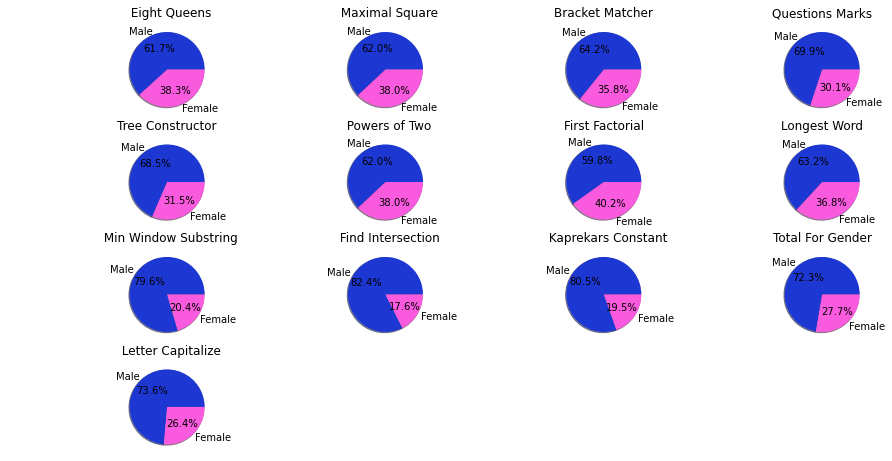

In [41]:
def show_pie_by_Challange(chall):
    mycolors=['#1d37d2','#f95ade' ] ;labels =    'Male', 'Female'
    plt.title(chall)
    return plt.pie(h[chall],colors=mycolors ,labels= labels ,autopct='%1.1f%%',shadow=True )

listChallange= h.columns[1:]
plt.figure(figsize=(15,10))

for i,chall in enumerate(listChallange):
    fig=plt.subplot(5,4,i+1)
    try:
        show_pie_by_Challange(chall)
    except KeyError:
        i-=1
        pass

In [42]:
df = pd.read_csv("data_gender_11_07_21.csv")

In [29]:
data_df["User_Gender"].value_counts()

Male      2317
Female     887
Name: User_Gender, dtype: int64

In [43]:
def create_df_of_currLang(lang):
    currLang=df[df['Programming_Lang']==lang]
    return currLang

def Table_of_Data_orderBy_GenderAndChallange():
    data = {'Gender': ['Male', 'Female'],  }
    listLangs=df['Programming_Lang'].value_counts().index.tolist() 
    print(listLang)
    finalDF = pd.DataFrame(data )

    for i in listLangs:
        currDF=create_df_of_currLang(i)
        maleCount=currDF[currDF['User_Gender']=='Male'].shape[0] 
        femaleCount=currDF[currDF['User_Gender']=='Female'].shape[0]
        if(maleCount>30 and femaleCount>30):
            finalDF.insert( 1 , i, [maleCount , femaleCount], True) 
    TotalMaleCount=df[df['User_Gender']=='Male'].shape[0]
    TotalFemaleCount=df[df['User_Gender']=='Female'].shape[0]  
    finalDF.insert( len(listLangs) , "Total For Gender", [TotalMaleCount , TotalFemaleCount], True)
    return finalDF
h=Table_of_Data_orderBy_GenderAndChallange()
h

Index(['C', 'Swift', 'Go', 'Ruby', 'JavaScript', 'Csharp', 'Java', 'Python',
       'Total For Gender'],
      dtype='object')


,Gender,C,Swift,Go,Ruby,JavaScript,Csharp,Java,Python,Total For Gender
0,Male,104,164,202,150,281,293,326,518,2317
1,Female,34,47,47,138,128,125,154,190,887


In [44]:
data_df['Programming_Lang'].value_counts().index

Index(['Python', 'Java', 'Csharp', 'JavaScript', 'PHP', 'Ruby', 'Go', 'Swift',
       'C'],
      dtype='object')

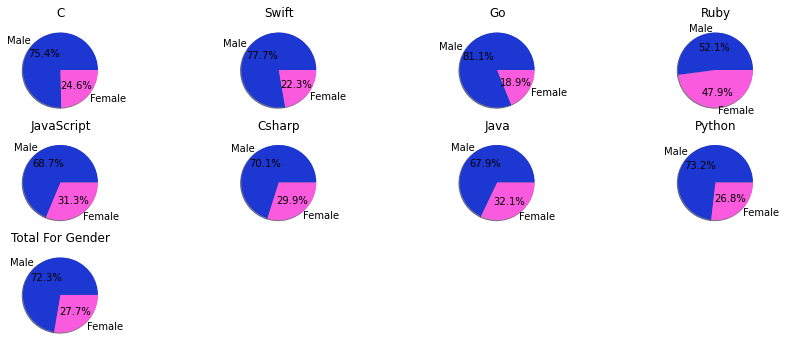

In [45]:
def show_pie_by_Lang(Lang):
    mycolors=['#1d37d2','#f95ade' ] ;labels =    'Male', 'Female'
    plt.title(Lang)
    return plt.pie(h[Lang],colors=mycolors ,labels= labels ,autopct='%1.1f%%',shadow=True )

listLang= h.columns[1:]
plt.figure(figsize=(15,10))

for i,lang in enumerate(listLang):
    fig=plt.subplot(5,4,i+1)
    try:
        show_pie_by_Lang(lang)
    except KeyError:
        i-=1
        pass